In [11]:
import micropip
await micropip.install(["kaibu-geojson-utils", "pyotritonclient"])

In [41]:
from js import fetch
import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from kaibu_geojson_utils import features_to_mask, mask_to_features

async def fetch_image(url, name=None, grayscale=False, transpose=False, size=None):
    response = await fetch(url)
    bytes = await response.arrayBuffer()
    bytes = bytes.to_py()
    buffer = io.BytesIO(bytes)
    buffer.name = name or url.split('?')[0].split('/')[1]
    image = Image.open(buffer)
    if grayscale:
        image = image.convert('L')
    if size:
        image = image.resize(size=size)
    image = np.array(image).astype('float32')
    if transpose:
        image = image.transpose(2, 0, 1)
    return image

def display_image(image, mask):
    # display the output
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(image)
    ax1.set_title('input image')
    ax2.imshow(mask)
    ax2.set_title('predicted mask')
    plt.show()

async def cellpose_segment(image, diameter=100):
    results = await execute([image.transpose(2, 0, 1), {'diameter': diameter}],
                server_url='https://ai.imjoy.io/triton',
                model_name='cellpose-python',
                decode_bytes=True)
    mask = results['mask'][0].copy()
    return mask

image = await fetch_image("https://images.proteinatlas.org/61448/1319_C10_2_blue_red_green.jpg")
image = resize(image, (image.shape[0] // 4, image.shape[1] // 4), anti_aliasing=True).astype('float32')
image.shape

(512, 512, 3)

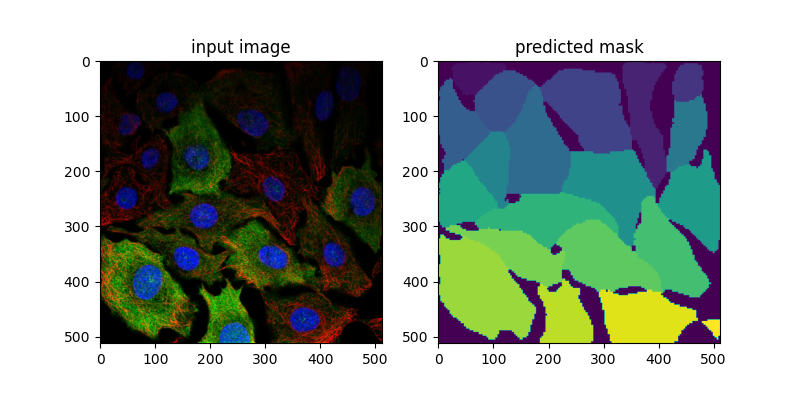

In [33]:
from pyotritonclient import execute

# image = await fetch_image('https://static.imjoy.io/img/img02.png', transpose=True)

results = await execute([image.transpose(2, 0, 1), {'diameter': 100}],
                        server_url='https://ai.imjoy.io/triton',
                        model_name='cellpose-python',
                        decode_bytes=True)
mask = results['mask'][0]
display_image(image.astype('uint8'), mask)

In [46]:
from imjoy import api

class ImJoyPlugin():
    async def setup(self):
        viewer = await api.createWindow(src="https://kaibu.org/#/app")
        
        # Add an image layer and annotation layer
        await viewer.view_image(image.astype('uint8'))
        annotation_layer = await viewer.add_shapes([], {"name": "annotation"})

        async def get_annotation():
            features = await annotation_layer.get_features()
            await api.alert(str(features))
            mask = features_to_mask(features, image.shape[:2])
        
        async def do_segmentation():
            mask = await cellpose_segment(image)
            # await viewer.view_image(mask, name="mask")
            polygons = mask_to_features(mask)
            await viewer.add_shapes(
                polygons,
                shape_type="polygon",
                edge_color="red",
                name="prediction",
            )

        await viewer.add_widget(
        {
            "_rintf": True,
            "name": "Control",
            "type": "control",
            "elements": [
                {
                    "type": "button",
                    "label": "Get Annotation",
                    "callback": get_annotation,
                },
                {
                    "type": "button",
                    "label": "Do Segmentation",
                    "callback": do_segmentation,
                },
            ],
        })

api.export(ImJoyPlugin())

<IPython.core.display.Javascript object>

<_GatheringFuture pending>